In [2]:
import numpy as np
import pandas as pd
import scipy.io
import os
import ieeg_funcs as ief
import dgFuncs as dg
from sklearn import preprocessing
import sys
import pickle
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn import metrics
%matplotlib inline

In [3]:
# Get list of models
model_name='code_testing_svm'
#model_name='code_testing'
path_dict=ief.get_path_dict()
model_path=os.path.join(path_dict['szr_ant_root'],'MODELS',model_name)
model_list=[]
for f in os.listdir(model_path):
    if f.endswith('.pkl'):
        model_list.append(f)
n_models=len(model_list)
print('%d models found' % n_models)
print(model_list)

metrics_fname=os.path.join(model_path,'classification_metrics.npz')
metrics_dict=np.load(metrics_fname)
print(metrics_dict.keys())
train_subs=metrics_dict['train_subs_list']
n_subs=len(train_subs)
print('%d training patients' % n_subs)
ftr_types=metrics_dict['ftr_types']
n_ftrs=len(ftr_types)
print('%d feature types' % n_ftrs)

10 models found
['model0.pkl', 'model1.pkl', 'model2.pkl', 'model3.pkl', 'model4.pkl', 'model5.pkl', 'model6.pkl', 'model7.pkl', 'model8.pkl', 'model9.pkl']
['valid_sens', 'C_ct', 'valid_bal_acc', 'train_subs_list', 'valid_spec', 'try_C', 'train_sens', 'pptn_missed_szrs', 'ftr_types', 'left_out_id', 'train_spec', 'mn_stim_latency', 'train_bal_acc']
10 training patients
5 feature types


In [4]:
model_list[0]
in_fname=os.path.join(path_dict['szr_ant_root'],'MODELS',model_name,model_list[0])
print(in_fname)
temp_model=joblib.load(in_fname)
#temp_model=pickle.load(open(in_fname,'rb'))
#args=pickle.load(open('args.pickle','rb'))
bro=temp_model.get_params()

/Users/davidgroppe/PycharmProjects/SZR_ANT/MODELS/code_testing_svm/model0.pkl


In [5]:
def n_clust(binary_ts):
    """ binary_ts is a boolean one dimensional time series. 
    This function returns the number of contiguous clusters of True values in the time series"""
    n_true_clust=0
    in_clust=False
    clust_onset_ids=list()
    clust_offset_ids=list()
    for t_ct, t in enumerate(binary_ts):
        if t==True and in_clust==False:
            # new cluster started
            in_clust=True
            n_true_clust+=1
            clust_onset_ids.append(t_ct)
        elif t==False and in_clust==True:
            # cluster just finished
            in_clust=False
            clust_offset_ids.append(t_ct)
    return n_true_clust, clust_onset_ids, clust_offset_ids

In [6]:
smooth_fact=np.arange(0.1,1.05,.05)
#smooth_fact=np.arange(0,8)
n_fact=len(smooth_fact)
group_auc=np.zeros((n_subs,n_fact))
group_detect=np.zeros((n_subs,n_fact)) # Mean # of seizures that were correctly detected
group_fp_clust=np.zeros((n_subs,n_fact)) # Mean # of false positive clusters
print('Trying these smoothing factors: {}'.format(smooth_fact))
bal_acc=np.zeros(n_subs) # GET RID OF THIS LATER

# Loop over subs
for sub_ct, lo_sub in enumerate(train_subs):
    # Import data for left out subject
    print('Importing data for %s' % lo_sub)
    
    # Get input data dimensions to pre-allocate memory
    n_szrs=np.nan
    ftr_dim=0 # the same for all szrs
    szr_n_tpts=list() # varies across szrs
    ftr_fnames=dict()
    for ftr_ct, ftr in enumerate(ftr_types):
        ftr_dir=os.path.join(path_dict['szr_ant_root'],'FTRS',ftr,lo_sub)
        ffile_list=[]
        for fname in os.listdir(ftr_dir):
            if fname.endswith('.npz'):
                ffile_list.append(fname)
        if np.isnan(n_szrs):
            # How many seizures does patient have?
            n_szrs=len(ffile_list)
        ftr_fnames[ftr_ct]=ffile_list
        in_file=os.path.join(ftr_dir,ffile_list[0])
        temp_ftrs=np.load(in_file)
        ftr_dim+=temp_ftrs['ftrs'].shape[0]
        if ftr_ct==0:
            # figure out the # of time points in each szr
            for szr_ct in range(n_szrs):
                in_file=os.path.join(ftr_dir,ffile_list[szr_ct])
                temp_ftrs=np.load(in_file)
                szr_n_tpts.append(temp_ftrs['ftrs'].shape[1])
    #print('%d szrs for %s' % (n_szrs,lo_sub))
    
    # Loop over szrs
    auc_this_sub=np.zeros((n_szrs,n_fact))
    for szr_ct in range(n_szrs):
        # Load input features
        in_ftrs=np.zeros((ftr_dim,szr_n_tpts[szr_ct]))
        ftr_ct=0
        for ftr_loop, ftr in enumerate(ftr_types):
            ftr_fname=os.path.join(path_dict['szr_ant_root'],'FTRS',ftr,lo_sub,ftr_fnames[ftr_loop][szr_ct])
            in_dict=np.load(ftr_fname)
            temp_n_ftrs=in_dict['ftrs'].shape[0]
            in_ftrs[ftr_ct:ftr_ct+temp_n_ftrs,:]=in_dict['ftrs']
            ftr_ct+=temp_n_ftrs
        y=in_dict['peri_ictal']
        
        # Apply classifiers
        #for class_ct, model in enumerate(model_list):
        # Load model that was trained WITHOUT the data from this subject
        model_fname=os.path.join(model_path,model_list[sub_ct])
        #print('Loading %s' % model_fname)
        temp_model=joblib.load(model_fname)
        y_hat=temp_model.predict(in_ftrs.T)
        
        # Compute balance accuracy to verify with existing code
        onset_tpts=(y==1)
        tpr=np.mean(y_hat[onset_tpts])
        preonset_tpts=(y==0)
        fpr=np.mean(y_hat[preonset_tpts])
        bal_acc[sub_ct]+=(tpr+(1-fpr))/(2*n_szrs) #balanced accuracy
        
        # Try various degrees of causal smoothing
        for fact_ct, try_fact in enumerate(smooth_fact):
            #smooth data
            y_hat_smooth=np.copy(y_hat)
            alph=try_fact
            #alph=1/(2**try_fact)
            for t in range(1,len(y_hat)):
                y_hat_smooth[t]=y_hat_smooth[t]*alph+y_hat_smooth[t-1]*(1-alph)
            # Was there at least one correct detection?
            group_detect[sub_ct,fact_ct]+=(np.sum(y_hat_smooth[onset_tpts]>=0.5)>0)/n_szrs
            n_contig_fp, _, _=n_clust(y_hat_smooth[preonset_tpts]>=0.5)
            group_fp_clust[sub_ct,fact_ct]+=n_contig_fp/n_szrs
            #print(np.sum(y_hat_smooth[onset_tpts]))
                
            # Compute AUC
            fpr, tpr, thresholds = metrics.roc_curve(y, y_hat_smooth, pos_label=1)
            auc_this_sub[szr_ct,fact_ct]=metrics.auc(fpr, tpr)
        group_auc[sub_ct,:]=np.mean(auc_this_sub,axis=0) #average across szrs
            

Trying these smoothing factors: [ 0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6   0.65
  0.7   0.75  0.8   0.85  0.9   0.95  1.  ]
Importing data for BH
Importing data for IM
Importing data for LM
Importing data for CV
Importing data for CJ
Importing data for CO
Importing data for IB
Importing data for JW
Importing data for RB
Importing data for TF


In [7]:
for fact_ct in range(n_fact):
    print('Smooth factor %f AUC=%f, detect=%f, # of fp clust=%f' % 
          (smooth_fact[fact_ct],
           np.mean(group_auc[:,fact_ct]),
           np.mean(group_detect[:,fact_ct]),
           np.mean(group_fp_clust[:,fact_ct])))
print('smooth factor of 1=NO smoothing')    
# print(np.mean(group_detect,axis=0))
# print(np.mean(group_fp_clust,axis=0))

Smooth factor 0.100000 AUC=0.611441, detect=0.900000, # of fp clust=5.410588
Smooth factor 0.150000 AUC=0.613477, detect=0.916667, # of fp clust=6.109412
Smooth factor 0.200000 AUC=0.616943, detect=0.916667, # of fp clust=6.450392
Smooth factor 0.250000 AUC=0.623049, detect=0.916667, # of fp clust=6.891373
Smooth factor 0.300000 AUC=0.629879, detect=0.925000, # of fp clust=7.463235
Smooth factor 0.350000 AUC=0.637256, detect=0.925000, # of fp clust=7.463235
Smooth factor 0.400000 AUC=0.645787, detect=0.925000, # of fp clust=7.535784
Smooth factor 0.450000 AUC=0.652280, detect=0.925000, # of fp clust=7.561667
Smooth factor 0.500000 AUC=0.660179, detect=0.975000, # of fp clust=8.094706
Smooth factor 0.550000 AUC=0.666414, detect=0.975000, # of fp clust=8.094706
Smooth factor 0.600000 AUC=0.671386, detect=0.975000, # of fp clust=8.094706
Smooth factor 0.650000 AUC=0.675920, detect=0.975000, # of fp clust=8.094706
Smooth factor 0.700000 AUC=0.680769, detect=0.975000, # of fp clust=8.094706

BH: bal_acc=0.761439, auc=0.607479
IM: bal_acc=0.979201, auc=0.837067
LM: bal_acc=0.665323, auc=0.508389
CV: bal_acc=0.883356, auc=0.801623
CJ: bal_acc=0.880667, auc=0.760292
CO: bal_acc=0.902508, auc=0.796285
IB: bal_acc=0.729636, auc=0.662739
JW: bal_acc=0.769836, auc=0.648049
RB: bal_acc=0.840380, auc=0.747048
TF: bal_acc=0.657150, auc=0.517117
0.806949425546


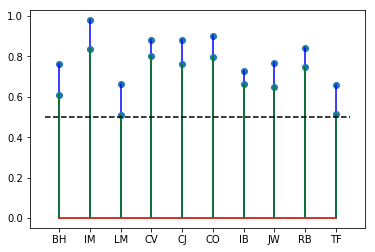

In [18]:
for sub_ct, sub in enumerate(train_subs):
    print('%s: bal_acc=%f, auc=%f' % (sub,bal_acc[sub_ct],group_auc[sub_ct,-1]))
print(np.mean(bal_acc))

plt.figure(2)
plt.clf()
plt.stem(bal_acc,'b');
plt.stem(group_auc[:,-1],'g')
xlim=plt.xlim()
plt.plot(xlim,[0.5, 0.5],'k--')
plt.xticks(np.arange(0,n_subs),train_subs);

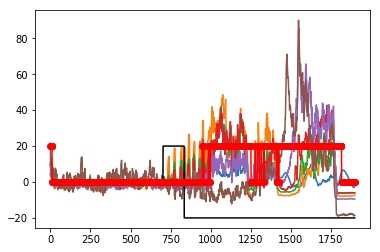

In [9]:
plt.figure(1)
plt.clf()
plt.plot(in_ftrs[:6,:].T);
#plt.plot(in_dict['peri_ictal']*20,'k-')
plt.plot(y*20,'k-')
plt.plot(y_hat*20,'r-o')
#plt.plot(y_hat_smooth*20,'g-o')

In [ ]:
n_bro, onset_ids, offset_ids=n_clust(y_hat)
n_bro, onset_ids, offset_ids=n_clust(y_hat[y==0])
print(n_bro)
print(onset_ids)
print(offset_ids)

In [ ]:
plt.figure(1)
plt.clf()
plt.plot(in_ftrs);

In [28]:
bro=np.load('/Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/MAG_LAG8/BH/BH_d10_sz1_bpmag_lag8.npz')
print(bro.keys())
print(bro['onset_chan_id'])
print(bro['onset_chan'])

['ftrs', 'time_wind_sec', 'peri_ictal', 'onset_chan_id', 'onset_chan', 'ftr_list']
0
LHD1-2


In [20]:
bro=np.load('/Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/MAG_LAG8/BH/BH_d10_sz1_bpmag_lag8.npz')

In [21]:
bro.keys()

['ftr_list', 'ftrs', 'peri_ictal', 'time_wind_sec']

In [ ]:
n_ftrs


In [ ]:
temp_ftrs.keys()
temp_ftrs['ftrs'].shape